# Implimentation GPT2 from Scratch using Numpy
 - https://www.lesswrong.com/posts/qxvihKpFMuc4tvuf4/recall-and-regurgitation-in-gpt2
 - https://github.com/jaymody/picoGPT
 - https://jaykmody.com/blog/gpt-from-scratch/
 - https://wikidocs.net/161980

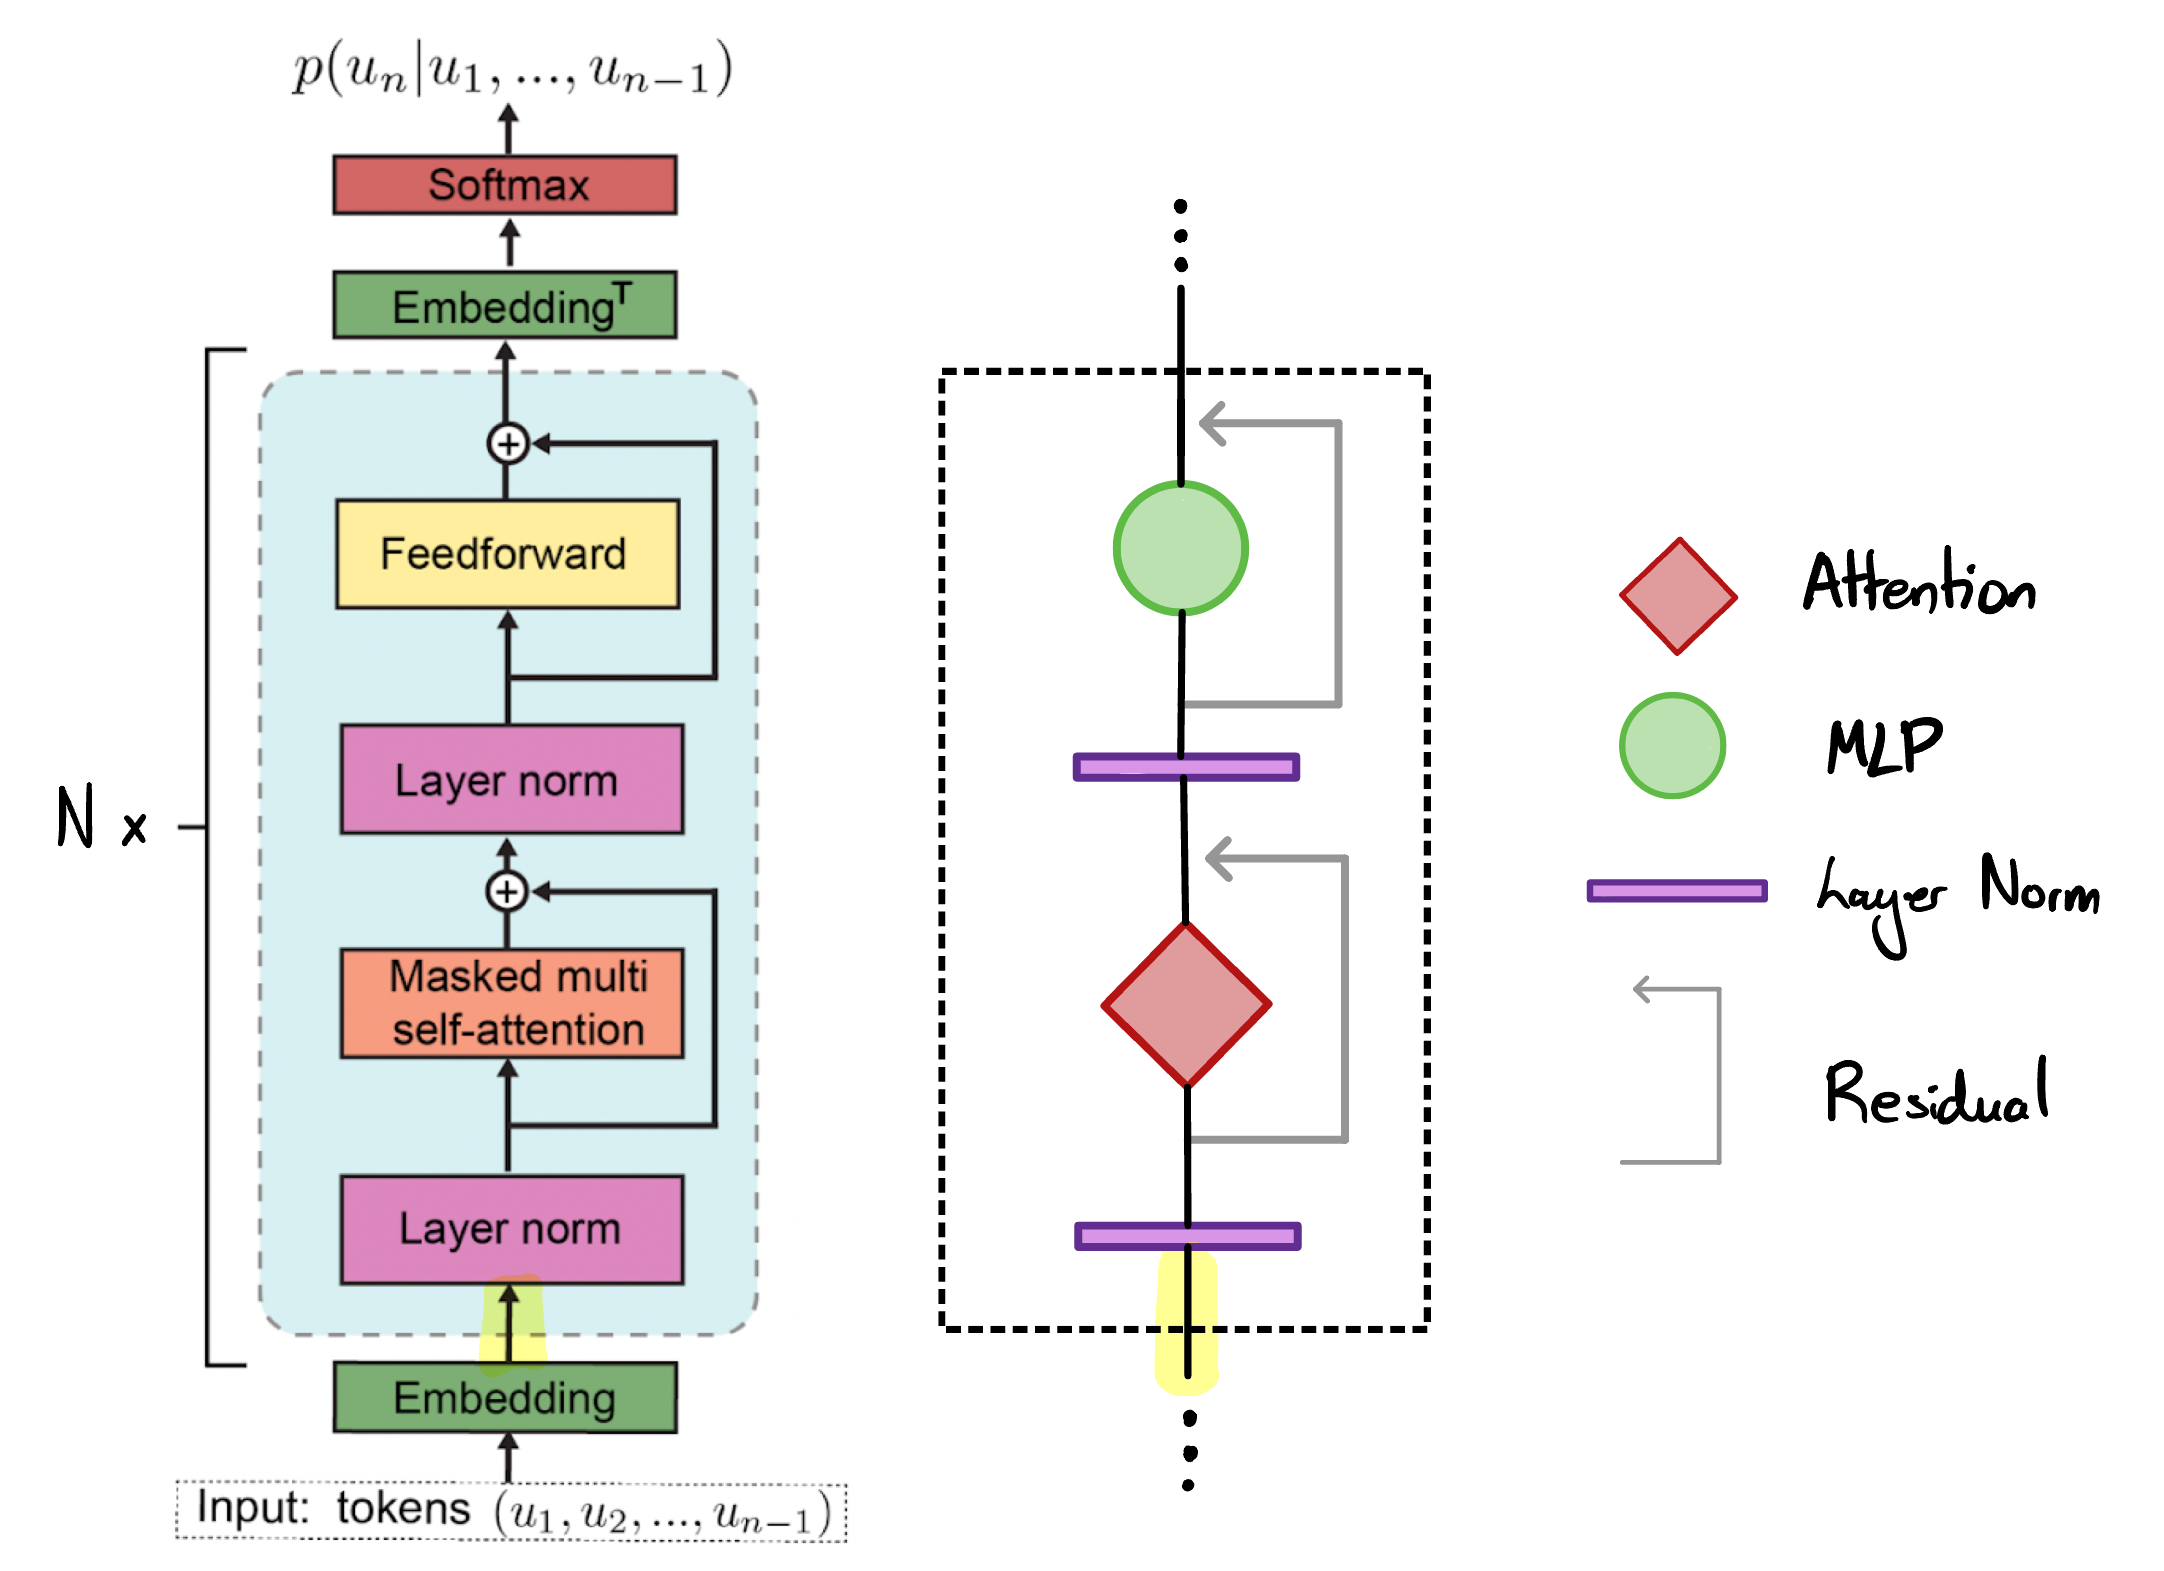

In [1]:
import numpy as np

## 01. Load pretrained GPT parameters

In [3]:
!git clone https://github.com/jaymody/picoGPT

Cloning into 'picoGPT'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 56 (delta 26), reused 14 (delta 14), pack-reused 23
Receiving objects: 100% (56/56), 17.79 KiB | 17.79 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
cd picoGPT

/content/picoGPT


## 02. Utill functions

In [7]:
def gelu(x):
  return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
  return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def layer_norm(x, g, b, eps: float = 1e-5):
  mean = np.mean(x, axis=-1, keepdims=True)
  variance = np.var(x, axis=-1, keepdims=True)
  x = (x - mean) / np.sqrt(variance + eps)
  return g * x + b

##. 03. Models

In [6]:
def linear(x, w, b):  # [m, in], [in, out], [out] -> [m, out]
    return x @ w + b

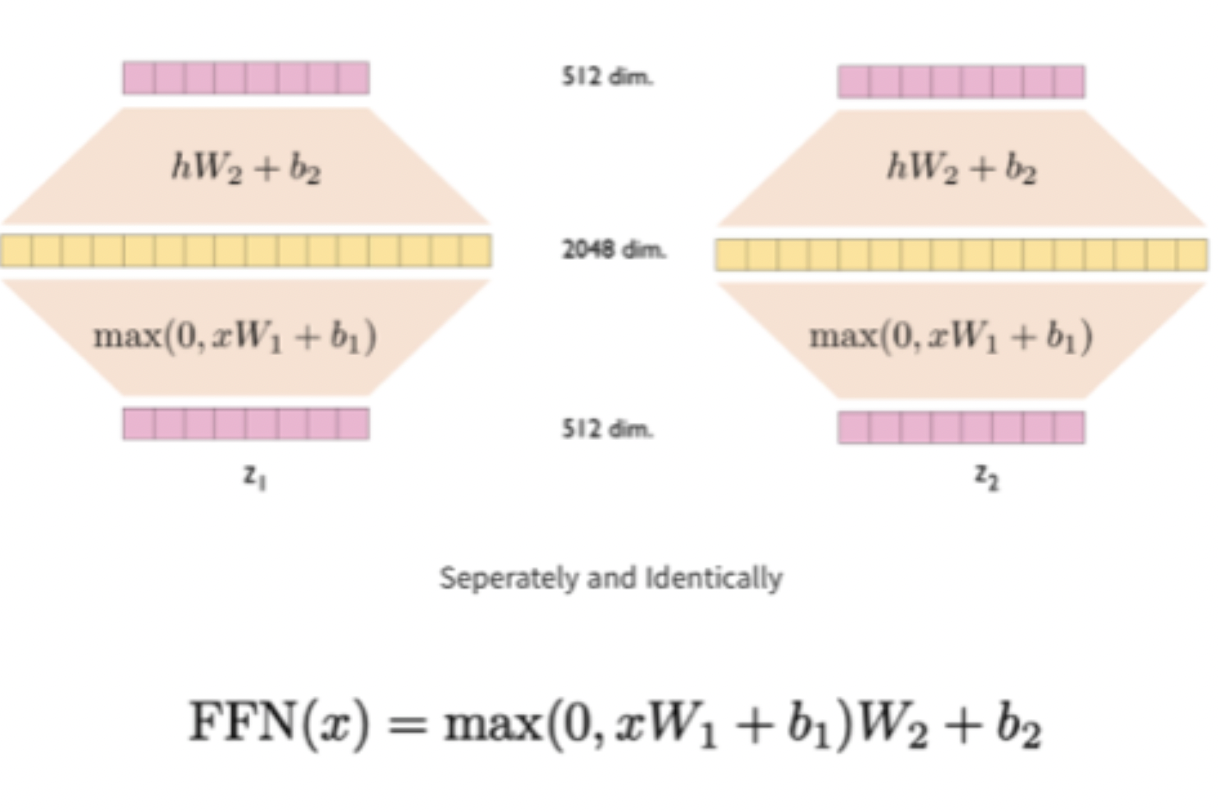

In [5]:
def ffn(x, c_fc, c_proj):  # [n_seq, n_embd] -> [n_seq, n_embd]

    a = gelu(linear(x, **c_fc))  # [n_seq, n_embd] -> [n_seq, 4*n_embd]
    x = linear(a, **c_proj)  # [n_seq, 4*n_embd] -> [n_seq, n_embd]

    return x

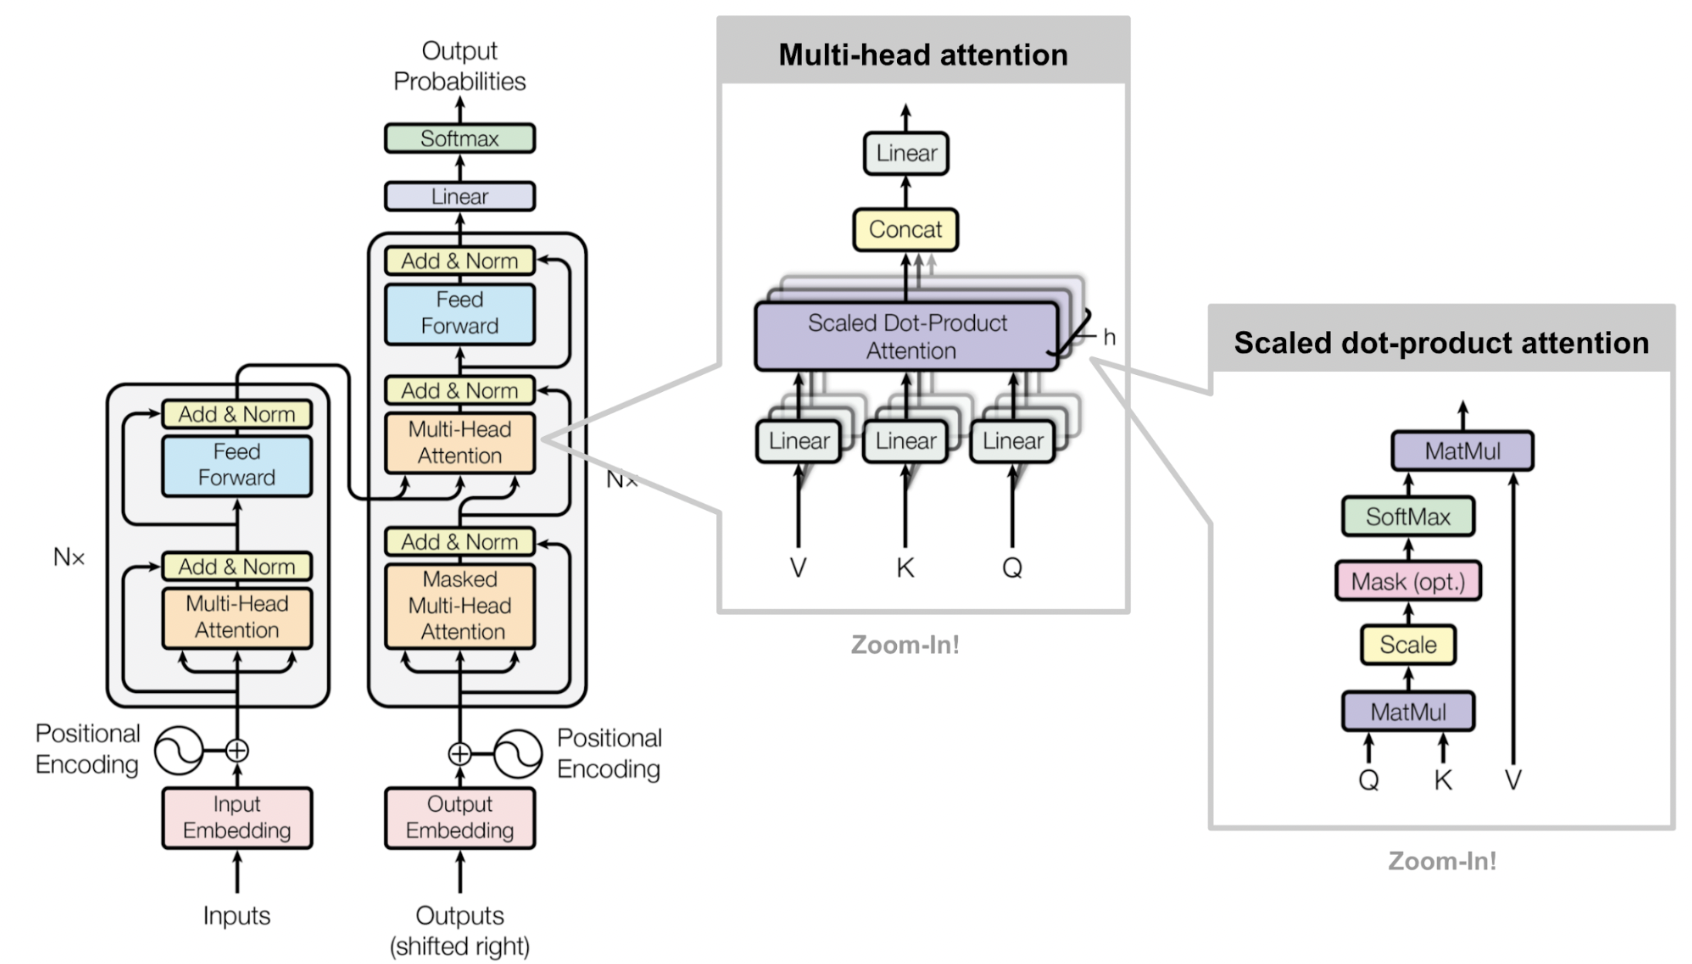

In [18]:
def attention(q, k, v, mask):  # [n_q, d_k], [n_k, d_k], [n_k, d_v], [n_q, n_k] -> [n_q, d_v]
    return softmax(q @ k.T / np.sqrt(q.shape[-1]) + mask) @ v

In [19]:
def mha(x, c_attn, c_proj, n_head):  # [n_seq, n_embd] -> [n_seq, n_embd]

    # Generate qkv
    x = linear(x, **c_attn)  # [n_seq, n_embd] -> [n_seq, 3*n_embd]

    # Split qkv
    qkv = np.split(x, 3, axis=-1)  # [n_seq, 3*n_embd] -> [3, n_seq, n_embd]

    # Split #of heads
    qkv_heads = list(map(lambda x: np.split(x, n_head, axis=-1), qkv))  # [3, n_seq, n_embd] -> [3, n_head, n_seq, n_embd/n_head]

    # Masking
    causal_mask = (1 - np.tri(x.shape[0], dtype=x.dtype)) * -1e10  # [n_seq, n_seq]

    # Attention for each haed
    out_heads = [attention(q, k, v, causal_mask) for q, k, v in zip(*qkv_heads)]  # [3, n_head, n_seq, n_embd/n_head] -> [n_head, n_seq, n_embd/n_head]

    # Concate heads
    x = np.hstack(out_heads)  # [n_head, n_seq, n_embd/n_head] -> [n_seq, n_embd]

    # output
    x = linear(x, **c_proj)  # [n_seq, n_embd] -> [n_seq, n_embd]

    return x



In [20]:
def transformer_block(x, mlp, attn, ln_1, ln_2, n_head):  # [n_seq, n_embd] -> [n_seq, n_embd]

    # multi-head causal self attention
    x = x + mha(layer_norm(x, **ln_1), **attn, n_head=n_head)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # position-wise feed forward network
    x = x + ffn(layer_norm(x, **ln_2), **mlp)  # [n_seq, n_embd] -> [n_seq, n_embd]

    return x

## 04. GPT2

In [21]:
def gpt2(inputs, wte, wpe, blocks, ln_f, n_head):  # [n_seq] -> [n_seq, n_vocab]

    # token + position embeddings
    x = wte[inputs] + wpe[range(len(inputs))]  # [n_seq] -> [n_seq, n_embd]

    # Forward computation * n_layer
    for block in blocks:
        x = transformer_block(x, **block, n_head=n_head)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # projection to vocab
    x = layer_norm(x, **ln_f)  # [n_seq, n_embd] -> [n_seq, n_embd]

    return x @ wte.T  # [n_seq, n_embd] -> [n_seq, n_vocab]


## 05. Main functions

In [22]:
def generate(inputs, params, n_head, n_tokens_to_generate):
    from tqdm import tqdm

    for _ in tqdm(range(n_tokens_to_generate), "generating"):

        logits = gpt2(inputs, **params, n_head=n_head)  # prediction of the next token
        next_id = np.argmax(logits[-1])  # greedy sampling

        inputs.append(int(next_id))  # append its predictions

    return inputs[len(inputs) - n_tokens_to_generate :]  # return generated ids



def main(prompt: str, n_tokens_to_generate: int = 40, model_size: str = "124M", models_dir: str = "models"):

    from utils import load_encoder_hparams_and_params

    # Load the pretrained tokenizer and parameters from OPEN AI gpt-2
    # Forexample, https://openaipublic.blob.core.windows.net/gpt-2/models/774M/vocab.bpe
    encoder, hparams, params = load_encoder_hparams_and_params(model_size, models_dir)

    # Tokenizer with BPE Tokenizer
    input_ids = encoder.encode(prompt)
    print( 'input_ids', input_ids )

    # Output ids based on the generate function
    output_ids = generate(input_ids, params, hparams["n_head"], n_tokens_to_generate)

    # Decode the generated IDs
    output_text = encoder.decode(output_ids)
    return output_text


In [24]:
# Example
main("Natural Language Processing (NLP) is",
    n_tokens_to_generate=10)

input_ids [35364, 15417, 28403, 357, 45, 19930, 8, 318]


generating: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


' a new approach to processing and processing of language.'